# Spectral Analysis

## Task
--redacted--

## Findings

- weird timestamp - specialized equipment?
    - measurements within single day, assume we want to be time independent, we could use it if measurements were effected by it though (daylight, temp, etc.), but would want more data (from more days, etc.)
    - each timestamp has one sample from each label
    - though I will assume they are independent
    - looks "unmelted" by timestamp - each label measurement at the same timestamp, like measuring a gradient
        - if the measurements are related by timestamp, we could have possibly used a different apprach
- labels 1-9
    - kind of categorical, but continous int so will leave it as is
    - can quantize at the end or leave float to preserve the remainder expressing predicted value confidence
- 50 samples per each label
    - already label-balanced or artificial dataset
    - dataset not big, might want to look out for train and test being balanced as well
- no NaNs, rounding, resolution
- low magnitude, ~0-2.5, don't need to rescale
- highly correlated features, as can be expected from continuous spectral measurements
    - corr matrix is naturally smooth, so the columns are likely not shuffled
    - corr matrix shows us there are likely just about 6 groups of highly correlated features - 6 DoF
    - no artifacts, eg. duplicate features
    - log-normal-ish distribution, possibly due to energy dependence on light requency
        - maybe odd peak at 1.5
- on scatterplots, we sometimes see what looks like a cluster outside of a linear cluster
    - usually with the 1 label
    - don't know if this there is some non-linear property that could cause this (eg. pH) - consult domain knowledge
    - could they be identified by being early in the dataset
        - we threw away the timestamp, but could the early samples be bad?
    - usually 50 of them - 10% of dataset
    - can sometimes isolate with HDBSCAN clustering, but not always
        - we could try sklearn.covariance.MinCovDet distance
    - no further observable artefacts

## Ideas
- check outliers
    - see if removing them improves performance
        - need to rebalance
    - use a model more robust to outliers
- train/test/validation split
    - dont have crazy ammount of samples, but have a lot of useful redundancy in features
- baseline
    - mean
    - ridge/ploynomail
- NN, I guess
    - grid hyper param search
    - convolution layer - to include continual nature of features
    - quantization layer at the output, or pooling?
- We could also use some dimensionality reduction since we have so many features, but they are mostly linearly correlated, so its probably not worth it
- evaluate based on RMSE, since its just numbers and we assume small error 2->3 is much better than big error 2->6
    - though task was to predict labels which for which we'd use crossentropy, but there'd have to be a good reason to warrant it

In [1]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from IPython.display import Markdown
from tqdm import trange

from sklearn.cluster import HDBSCAN
from sklearn.covariance import MinCovDet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import random

torch.manual_seed(0)

%matplotlib inline

In [2]:
df = pd.read_csv('data/etnetera_task/spectra.csv')
df = df.rename(columns={'Unnamed: 0': 'timestamp'})

In [3]:
display(df.sort_values(['timestamp', 'labels']))

display(Markdown('### Labels per timestamp'))
display(df.groupby('timestamp')['labels'].value_counts().groupby('timestamp').count().values)

df = df.drop(columns=['timestamp'])

,timestamp,labels,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,601,602
0,1/02/2018,1,2.397526,2.394200,2.388952,2.381282,2.371906,2.360940,2.349092,2.336749,...,0.109473,0.111015,0.113123,0.115745,0.118939,0.122773,0.127250,0.132313,0.137997,0.144151
50,1/02/2018,2,2.283223,2.280655,2.276095,2.268845,2.259162,2.247454,2.235045,2.222827,...,0.106453,0.107973,0.109957,0.112412,0.115310,0.118662,0.122522,0.126909,0.131909,0.137457
100,1/02/2018,3,2.317585,2.314886,2.310067,2.302449,2.292517,2.280822,2.268373,2.255928,...,0.111111,0.112733,0.114631,0.116975,0.119709,0.122953,0.126722,0.130996,0.135854,0.141286
150,1/02/2018,4,2.283205,2.280553,2.275210,2.267265,2.257764,2.247090,2.236765,2.226475,...,0.108463,0.109455,0.110973,0.113030,0.115705,0.119066,0.123110,0.127821,0.133187,0.139064
200,1/02/2018,5,2.311894,2.310037,2.305413,2.297529,2.287025,2.275034,2.262815,2.250777,...,0.112975,0.114307,0.116114,0.118407,0.121267,0.124733,0.128859,0.133671,0.139098,0.145039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,1/02/2018.9,5,2.345222,2.342679,2.337962,2.330481,2.320580,2.309522,2.298044,2.286299,...,0.115305,0.117003,0.119200,0.121991,0.125423,0.129357,0.133762,0.138502,0.143530,0.149021
259,1/02/2018.9,6,2.288603,2.285535,2.280187,2.271963,2.261320,2.249955,2.238148,2.226957,...,0.116040,0.117246,0.118885,0.120966,0.123618,0.126869,0.130853,0.135437,0.140679,0.146529
309,1/02/2018.9,7,2.289325,2.286365,2.281595,2.275049,2.266420,2.256298,2.245369,2.234172,...,0.114447,0.115590,0.117334,0.119817,0.122959,0.126770,0.131120,0.135931,0.141159,0.146807
359,1/02/2018.9,8,2.325097,2.322801,2.318001,2.310276,2.300107,2.288313,2.275948,2.263756,...,0.117816,0.119077,0.120940,0.123379,0.126272,0.129633,0.133450,0.137775,0.142708,0.148272


### Labels per timestamp

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9])

## df

,labels,2,3,4,5,6,7,8,9,10,...,593,594,595,596,597,598,599,600,601,602
0,1,2.397526,2.394200,2.388952,2.381282,2.371906,2.360940,2.349092,2.336749,2.323827,...,0.109473,0.111015,0.113123,0.115745,0.118939,0.122773,0.127250,0.132313,0.137997,0.144151
1,1,2.399526,2.396723,2.391678,2.383280,2.372825,2.361160,2.348541,2.336346,2.324357,...,0.108937,0.110649,0.112845,0.115586,0.118847,0.122642,0.127013,0.131837,0.137191,0.143028
2,1,2.396475,2.393600,2.388446,2.380985,2.371319,2.359930,2.348114,2.336348,2.324462,...,0.108358,0.110062,0.112391,0.115298,0.118736,0.122774,0.127359,0.132500,0.138217,0.144524
3,1,2.406880,2.404243,2.399203,2.391142,2.380536,2.368569,2.356339,2.344046,2.331534,...,0.110105,0.111836,0.114057,0.116744,0.119888,0.123524,0.127728,0.132561,0.138030,0.144085
4,1,2.409883,2.407017,2.401310,2.392669,2.381365,2.368603,2.355518,2.342792,2.331235,...,0.110129,0.111469,0.113277,0.115589,0.118503,0.122092,0.126346,0.131227,0.136840,0.143176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,9,2.342263,2.340977,2.336841,2.329997,2.320566,2.309092,2.296712,2.283835,2.270525,...,0.124549,0.126137,0.128178,0.130633,0.133496,0.136854,0.140747,0.145175,0.150136,0.155510
446,9,2.341321,2.337928,2.331601,2.322100,2.310171,2.296914,2.284369,2.272224,2.260710,...,0.120460,0.122389,0.124718,0.127474,0.130560,0.134146,0.138140,0.142645,0.147620,0.153031
447,9,2.332630,2.328758,2.322815,2.314416,2.303985,2.292807,2.281126,2.269446,2.257631,...,0.121400,0.123081,0.125230,0.127813,0.130817,0.134254,0.138230,0.142814,0.148050,0.153915
448,9,2.332112,2.328909,2.323220,2.314949,2.304700,2.293027,2.281397,2.270268,2.258665,...,0.123051,0.124545,0.126341,0.128536,0.131220,0.134530,0.138494,0.143144,0.148405,0.154305


## Check types

float64    601
int64        1
dtype: int64

## Label balance

1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: labels, dtype: int64

## Check NaNs

450.0    602
Name: count, dtype: int64

## Check range, rounding, resolution

<Axes: >

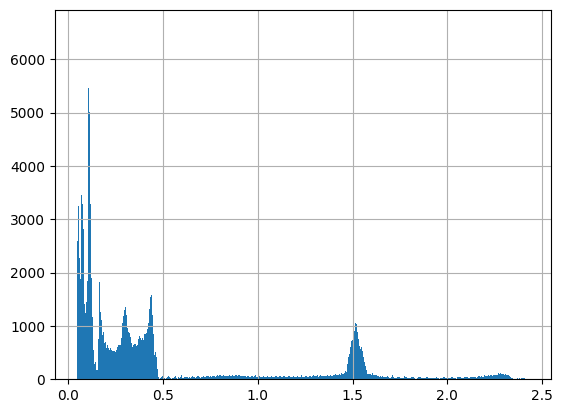

In [4]:
display(Markdown('## df'))
display(df)

display(Markdown('## Check types'))
display(df.dtypes.value_counts())

display(Markdown('## Label balance'))
display(df['labels'].value_counts())

display(Markdown('## Check NaNs'))
display(df.describe().loc['count'].value_counts())

display(Markdown('## Check range, rounding, resolution'))
df.iloc[:,1:].unstack().hist(bins=1000)

In [5]:
profile = ProfileReport(minimal=True)
profile.config.interactions.targets = ["labels"]
profile.config.interactions.continuous = False
profile.df = df.iloc[:,:11]
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Pearson

,labels,2,3,4,5,6,7,8,9,10,...,593,594,595,596,597,598,599,600,601,602
labels,1.000000,-0.207279,-0.206398,-0.205160,-0.203232,-0.200974,-0.198653,-0.196510,-0.195201,-0.194169,...,0.862692,0.859724,0.856131,0.850978,0.844189,0.835498,0.825442,0.814655,0.802885,0.790599
2,-0.207279,1.000000,0.999838,0.999434,0.998847,0.998130,0.997407,0.996775,0.996292,0.995991,...,0.192977,0.199113,0.206874,0.217173,0.230327,0.246412,0.264182,0.282995,0.302799,0.323022
3,-0.206398,0.999838,1.000000,0.999849,0.999415,0.998728,0.997924,0.997159,0.996523,0.996102,...,0.194020,0.200192,0.207981,0.218300,0.231474,0.247589,0.265384,0.284208,0.303999,0.324193
4,-0.205160,0.999434,0.999849,1.000000,0.999830,0.999323,0.998576,0.997763,0.997008,0.996454,...,0.195120,0.201346,0.209178,0.219521,0.232710,0.248839,0.266641,0.285462,0.305232,0.325390
5,-0.203232,0.998847,0.999415,0.999830,1.000000,0.999804,0.999269,0.998539,0.997750,0.997086,...,0.196782,0.203072,0.210951,0.221321,0.234518,0.250645,0.268441,0.287256,0.307013,0.327154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.835498,0.246412,0.247589,0.248839,0.250645,0.252606,0.254408,0.255925,0.256315,0.256340,...,0.983567,0.987703,0.992231,0.996264,0.999001,1.000000,0.998954,0.995880,0.991319,0.985929
599,0.825442,0.264182,0.265384,0.266641,0.268441,0.270390,0.272214,0.273765,0.274174,0.274209,...,0.979993,0.983517,0.987810,0.992260,0.996155,0.998954,1.000000,0.998879,0.995752,0.991172
600,0.814655,0.282995,0.284208,0.285462,0.287256,0.289201,0.291053,0.292643,0.293089,0.293135,...,0.976763,0.979504,0.983129,0.987363,0.991756,0.995880,0.998879,1.000000,0.998886,0.995794
601,0.802885,0.302799,0.303999,0.305232,0.307013,0.308952,0.310826,0.312444,0.312929,0.312980,...,0.973610,0.975694,0.978559,0.982216,0.986528,0.991319,0.995752,0.998886,1.000000,0.998910


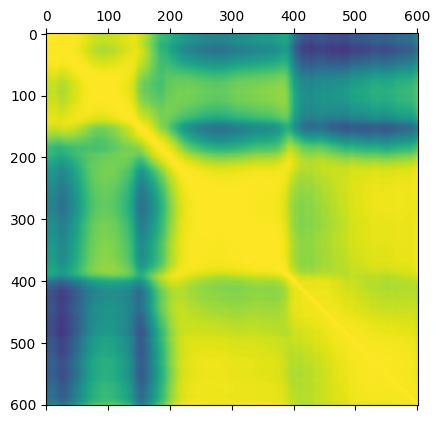

## Spearman

,labels,2,3,4,5,6,7,8,9,10,...,593,594,595,596,597,598,599,600,601,602
labels,1.000000,0.106901,0.107742,0.108445,0.108451,0.109081,0.109061,0.110101,0.111181,0.112970,...,0.877220,0.874957,0.871896,0.868325,0.862740,0.855618,0.847005,0.836444,0.823077,0.806411
2,0.106901,1.000000,0.999569,0.998624,0.997399,0.995949,0.994445,0.993233,0.992337,0.991728,...,0.455114,0.460481,0.467780,0.476166,0.484905,0.497350,0.511054,0.526986,0.544055,0.564933
3,0.107742,0.999569,1.000000,0.999559,0.998637,0.997244,0.995577,0.994107,0.992908,0.992076,...,0.456157,0.461611,0.468948,0.477362,0.486175,0.498715,0.512541,0.528537,0.545631,0.566493
4,0.108445,0.998624,0.999559,1.000000,0.999569,0.998507,0.996953,0.995364,0.993908,0.992788,...,0.456784,0.462288,0.469685,0.478194,0.487143,0.499810,0.513765,0.529770,0.546784,0.567492
5,0.108451,0.997399,0.998637,0.999569,1.000000,0.999530,0.998364,0.996906,0.995371,0.994009,...,0.457223,0.462782,0.470179,0.478709,0.487685,0.500337,0.514298,0.530268,0.547258,0.567894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.855618,0.497350,0.498715,0.499810,0.500337,0.501453,0.501679,0.503025,0.504212,0.506146,...,0.971521,0.978746,0.986393,0.993539,0.998235,1.000000,0.998158,0.992990,0.985531,0.976347
599,0.847005,0.511054,0.512541,0.513765,0.514298,0.515418,0.515770,0.517187,0.518490,0.520470,...,0.965784,0.971864,0.979045,0.986891,0.993554,0.998158,1.000000,0.997975,0.992699,0.984769
600,0.836444,0.526986,0.528537,0.529770,0.530268,0.531359,0.531887,0.533417,0.534842,0.536869,...,0.960796,0.965376,0.971363,0.978805,0.986263,0.992990,0.997975,1.000000,0.997944,0.992482
601,0.823077,0.544055,0.545631,0.546784,0.547258,0.548303,0.549034,0.550767,0.552433,0.554593,...,0.956083,0.959401,0.964145,0.970574,0.977792,0.985531,0.992699,0.997944,1.000000,0.997896


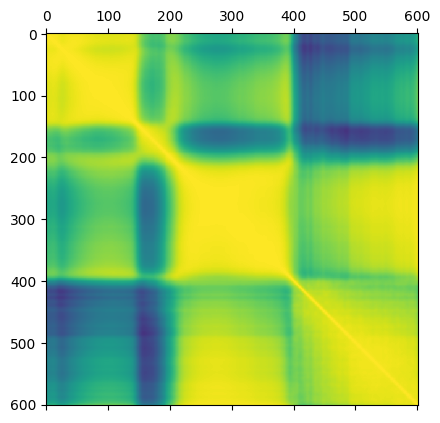

## Pearson correlation hist

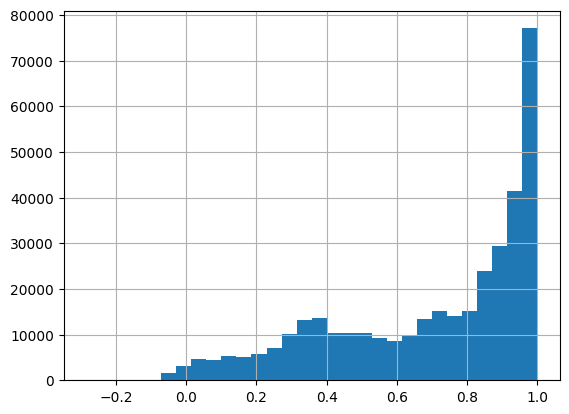

1.000000    602
0.917445      2
0.995593      2
0.995451      2
0.995300      2
           ... 
0.691169      2
0.693384      2
0.695788      2
0.698060      2
0.998910      2
Length: 180902, dtype: int64

In [6]:
display(Markdown('## Pearson'))
display(df.corr(method='pearson'))
plt.matshow(df.corr(method='pearson'))
plt.show()

display(Markdown('## Spearman'))
display(df.corr(method='spearman'))
plt.matshow(df.corr(method='spearman'))
plt.show()

display(Markdown('## Pearson correlation hist'))
df.corr(method='pearson').unstack().hist(bins=30)
plt.show()

display(df.corr(method='pearson').unstack().value_counts())

## Correlations

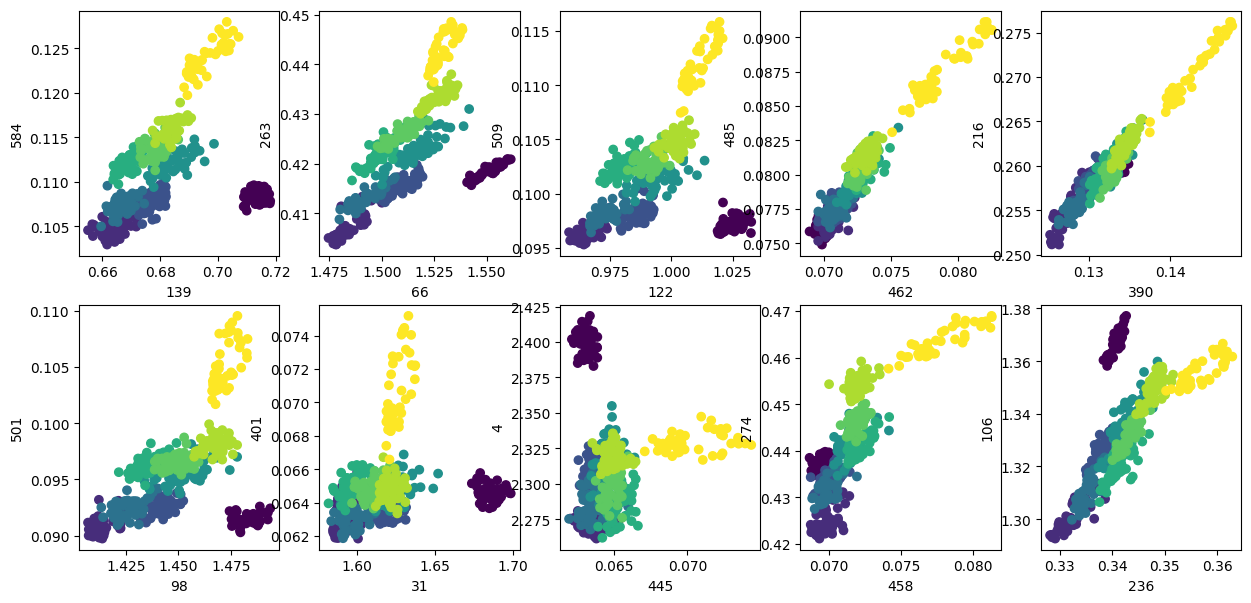

### Outlier cluster

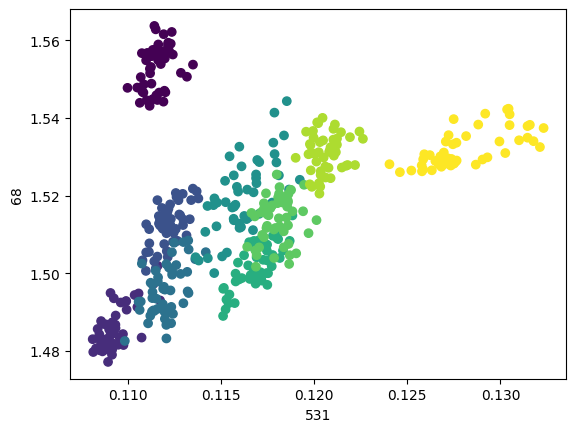

In [7]:
display(Markdown('## Correlations'))

random.seed(1)

plt_w, plt_h = 5, 2
fig, axs = plt.subplots(plt_h, plt_w, figsize=(15, 7))

for i in range(10):
    x_, y_ = random.sample(list(df.columns[1:]), 2)
    ax = axs[i//plt_w, i%plt_w]
    ax.scatter(x=df[x_], y=df[y_], c=df["labels"])
    ax.set(xlabel=x_, ylabel=y_)

plt.show()

display(Markdown('### Outlier cluster'))
plt.scatter(x=df["531"], y=df["68"], c=df["labels"])
plt.gca().set(xlabel="531", ylabel="68")
plt.show()

### Outlier cluster

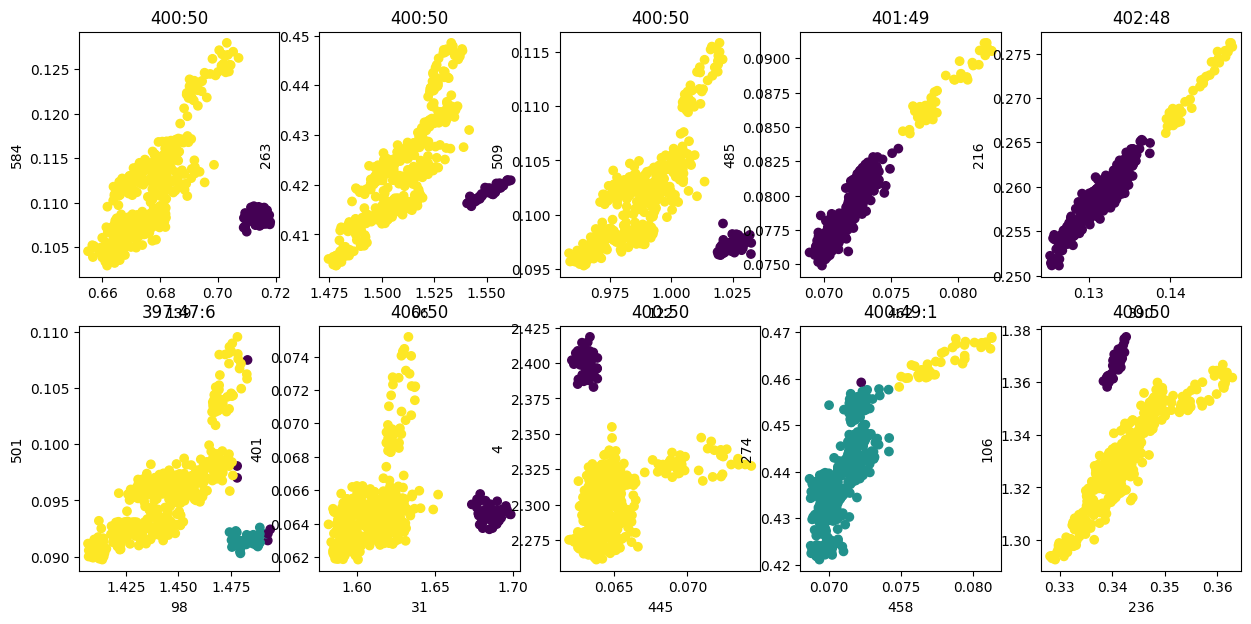

In [8]:
display(Markdown('### Outlier cluster'))

random.seed(1)

plt_w, plt_h = 5, 2
fig, axs = plt.subplots(plt_h, plt_w, figsize=(15, 7))

for i in range(10):
    x_, y_ = random.sample(list(df.columns[1:]), 2)
    sample_df = df.loc[:, ["labels", x_, y_]].copy()

    dbscan = HDBSCAN(cluster_selection_epsilon=0.01,).fit_predict(sample_df.iloc[:,1:])
    sample_df['cluster'] = dbscan
    
    ax = axs[i//plt_w, i%plt_w]
    ax.scatter(x=sample_df[x_], y=sample_df[y_], c=sample_df["cluster"])
    ax.set(xlabel=x_, ylabel=y_, title=':'.join(list(sample_df['cluster'].value_counts().astype(str).values)))

plt.show()

### MCD based outliers

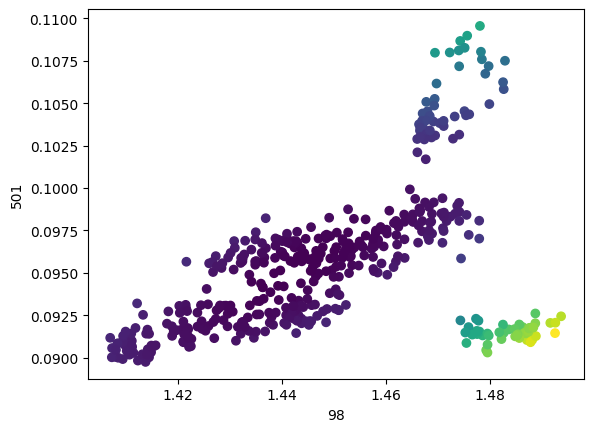

In [9]:
display(Markdown('### MCD based outliers'))

x_, y_ = "98", "501"
sample_df = df.loc[:, ["labels", x_, y_]].copy()

mcd = MinCovDet().fit(sample_df[[x_, y_]])
sample_df['mcd_dist'] = mcd.dist_

plt.scatter(x=sample_df[x_], y=sample_df[y_], c=sample_df['mcd_dist'])
plt.gca().set(xlabel=x_, ylabel=y_)
plt.show()

In [10]:
display(Markdown('## Predictive modeling'))

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=0,
    shuffle=True,
    stratify=y
)

X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test,
    test_size=0.28,
    random_state=0,
    shuffle=True,
    stratify=y_test
)

display(Markdown('### X: check info leak'))
display(X_train.head())


eval_df = pd.DataFrame(y_test).rename(columns={'labels': 'y_truth'})
validation_df = pd.DataFrame(y_valid).rename(columns={'labels': 'y_truth'})

print('train samples:', len(X_train), ', label spit:', ':'.join(y_train.value_counts().astype(str).values))
print('test samples:', len(X_test), ', label spit:', ':'.join(y_test.value_counts().astype(str).values))
print('valid samples:', len(X_valid), ', label spit:', ':'.join(y_valid.value_counts().astype(str).values))

## Predictive modeling

### X: check info leak

,2,3,4,5,6,7,8,9,10,11,...,593,594,595,596,597,598,599,600,601,602
150,2.283205,2.280553,2.275210,2.267265,2.257764,2.247090,2.236765,2.226475,2.215635,2.203805,...,0.108463,0.109455,0.110973,0.113030,0.115705,0.119066,0.123110,0.127821,0.133187,0.139064
359,2.325097,2.322801,2.318001,2.310276,2.300107,2.288313,2.275948,2.263756,2.251642,2.239439,...,0.117816,0.119077,0.120940,0.123379,0.126272,0.129633,0.133450,0.137775,0.142708,0.148272
247,2.317871,2.314789,2.309790,2.302427,2.292603,2.281733,2.270497,2.259763,2.248750,2.237368,...,0.110925,0.112472,0.114570,0.117251,0.120440,0.124147,0.128457,0.133281,0.138568,0.144270
14,2.406311,2.403885,2.398699,2.390930,2.380877,2.368989,2.356463,2.344157,2.331691,2.318227,...,0.110331,0.111530,0.113222,0.115565,0.118644,0.122534,0.127089,0.132326,0.138069,0.144269
354,2.333405,2.330522,2.325399,2.317574,2.307204,2.295538,2.283620,2.272199,2.261534,2.250554,...,0.118278,0.119769,0.121530,0.123760,0.126576,0.130041,0.134041,0.138603,0.143678,0.149262


train samples: 315 , label spit: 35:35:35:35:35:35:35:35:35
test samples: 97 , label spit: 11:11:11:11:11:11:11:10:10
valid samples: 38 , label spit: 5:5:4:4:4:4:4:4:4


In [11]:
display(Markdown('## Mean'))

y_pred = np.zeros(y_test.shape)
mean = y_train.mean()
y_pred[:] = mean

var = mean_squared_error(y_test, y_pred, squared=False)
print(f"{var=}")
eval_df['y_mean'] = y_pred.copy()

y_pred = np.zeros(y_valid.shape)
y_pred[:] = mean
validation_df['y_mean'] = y_pred.copy()

## Mean

var=2.574658419942623


In [12]:
display(Markdown('## Linear regression'))

lin_regressor = LinearRegression().fit(X_train, y_train)
y_pred = lin_regressor.predict(X_test)
eval_df['y_linreg'] = y_pred

var = mean_squared_error(y_test, y_pred, squared=False)
print(f"{var=}")

validation_df['y_linreg'] = lin_regressor.predict(X_valid)

## Linear regression

var=0.38249746711797156


In [13]:
display(Markdown('## Ridge regression'))

ridge_regressor = Ridge(alpha=0.001).fit(X_train, y_train)
y_pred = ridge_regressor.predict(X_test)
eval_df['y_rigreg'] = y_pred

var = mean_squared_error(y_test, y_pred, squared=False)
print(f"{var=}")

validation_df['y_rigreg'] = ridge_regressor.predict(X_valid)

## Ridge regression

var=0.17271253455674362


In [14]:
display(Markdown('## Random forest regression'))

tree_regressor = RandomForestRegressor(
    max_depth=5,
    n_estimators=10*6,
    random_state=0,
).fit(X_train, y_train)
y_pred = tree_regressor.predict(X_test)
eval_df['y_treereg'] = y_pred

var = mean_squared_error(y_test, y_pred, squared=False)
print(f"{var=}")

validation_df['y_treereg'] = tree_regressor.predict(X_valid)

## Random forest regression

var=0.23955997650462152


In [15]:
display(Markdown('## MLP NN regression'))

nn_regressor = MLPRegressor(
    alpha=0.001,
    max_iter=1000000,
    batch_size=len(X_train),
    random_state=0,
    hidden_layer_sizes=[25, 6],
    solver='lbfgs', # apparently good
).fit(X_train, y_train)
y_pred = nn_regressor.predict(X_test)
eval_df['y_mlpnn'] = y_pred

train_var = mean_squared_error(y_train, nn_regressor.predict(X_train), squared=False)
var = mean_squared_error(y_test, y_pred, squared=False)
print(f"{train_var=}")
print(f"{var=}")

validation_df['y_mlpnn'] = nn_regressor.predict(X_valid)

## MLP NN regression

train_var=0.1833632082709032
var=0.1908503052025477


In [16]:
display(Markdown('## Custom NN regression'))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(601, 25),
            nn.Linear(25, 6),
            nn.Linear(6, 1),
        )

    def forward(self, x):
        y = self.linear_stack(x)
        return y

model = NeuralNetwork().to("cpu")
print(model)

learning_rate = 1
batch_size = len(X_train)
epochs = 100

def train_loop(dataloader, model, loss_fn, optimizer, bar):
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        
        loss = loss_fn(pred, y.unsqueeze(1))

        loss.backward()
        
        def cb():
            return loss
        
        optimizer.step(cb)
        optimizer.zero_grad()

    return loss


def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    return test_loss

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train.astype(np.float32).values),
    torch.tensor(y_train.astype(np.float32).values)
), batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test.astype(np.float32).values),
    torch.tensor(y_test.astype(np.float32).values)
), batch_size=batch_size, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)


with trange(epochs) as bar:
    for _ in bar:
        loss = train_loop(train_dataloader, model, loss_fn, optimizer, bar)
        test_loss = test_loop(test_dataloader, model, loss_fn)
        bar.set_description(f'train_loss: {loss:0.2f} test_loss: {test_loss:0.2f}')

y_pred = model(torch.tensor(X_test.astype(np.float32).values)).detach().numpy()
var = mean_squared_error(y_test, y_pred, squared=False)
eval_df['y_torchnn'] = y_pred

print(f"{var=}")

validation_df['y_torchnn'] = model(torch.tensor(X_valid.astype(np.float32).values)).detach().numpy()

## Custom NN regression

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=601, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=6, bias=True)
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)


train_loss: 0.06 test_loss: 0.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.75it/s]

var=0.2296603108229193


In [24]:
display(Markdown("### Test set"))

display(eval_df)

display(Markdown("### RSME"))
eval_df.iloc[:,1:].apply(lambda s: mean_squared_error(y_test, s, squared=False))

### Test set

,y_truth,y_mean,y_linreg,y_rigreg,y_treereg,y_mlpnn,y_torchnn
419,9,5.0,8.912362,8.942228,9.000000,8.871499,8.916955
316,7,5.0,6.676271,6.539479,6.517333,6.512876,6.604144
327,7,5.0,6.097251,6.582510,6.450667,6.586485,6.637240
284,6,5.0,5.602070,5.951964,5.998551,5.919390,5.795918
391,8,5.0,8.706958,8.134669,8.000000,8.118386,8.145581
...,...,...,...,...,...,...,...
99,2,5.0,2.501086,2.229645,2.000000,2.152020,2.051281
121,3,5.0,3.098536,3.032991,3.016667,3.055785,3.100520
245,5,5.0,5.158448,5.067096,5.000000,5.153827,5.127434
396,8,5.0,7.992422,8.159848,8.000000,8.112311,8.260541


### RSME

y_mean       2.574658
y_linreg     0.382497
y_rigreg     0.172713
y_treereg    0.239560
y_mlpnn      0.190850
y_torchnn    0.229660
dtype: float64

In [25]:
display(Markdown("### Validation set"))

display(validation_df)

display(Markdown("### RSME"))
validation_df.iloc[:,1:].apply(lambda s: mean_squared_error(y_valid, s, squared=False))

### Validation set

,y_truth,y_mean,y_linreg,y_rigreg,y_treereg,y_mlpnn,y_torchnn
169,4,5.0,3.300740,3.901181,3.383333,3.920707,3.984500
407,9,5.0,9.404227,8.958573,9.000000,8.946235,8.846231
258,6,5.0,6.124325,6.024020,6.016459,5.926275,6.250228
351,8,5.0,7.975781,8.053914,7.983333,8.090194,8.284427
65,2,5.0,1.322821,2.218051,2.000000,2.216733,2.152746
9,1,5.0,1.853461,0.945549,1.000000,0.932487,1.106965
47,1,5.0,1.530268,1.126489,1.000000,1.055997,1.186558
417,9,5.0,8.735990,8.956160,9.000000,8.929936,9.045098
277,6,5.0,5.496171,5.968611,6.498265,5.942267,6.177957
50,2,5.0,2.500189,1.998289,2.000000,2.024677,2.049944


### RSME

y_mean       2.600607
y_linreg     0.522995
y_rigreg     0.200422
y_treereg    0.237180
y_mlpnn      0.214532
y_torchnn    0.263211
dtype: float64